In [57]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [58]:
def get_climate_data(year):
    climate_data_directory = './historical_climate_data'
    data = pd.read_csv(f'{climate_data_directory}/canada_{year}.csv')
    return data

def get_fire_data(year):
    fire_data_directory = './historical_fire_data/grouped'
    data = pd.read_csv(f'{fire_data_directory}/grouped_canada_{year}.csv')
    data['fire_occurrence'] = (data['confidence'] >= 90).astype(int)
    return data

In [59]:
import pandas as pd
def combine_fire_and_climate_data(fire_data, climate_data):
    
    fire_data.rename(columns={'acq_date': 'date'}, inplace=True)
    # Columns to join on
    on_columns = ['date', 'daynight', 'latitude', 'longitude']

    result = pd.merge(fire_data, climate_data, how='left', left_on=on_columns, right_on=on_columns)
    result = result.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])
    return result

In [60]:
def prepare_model_data():
    years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
    model_data = None
    for year in years:
        climate_data = get_climate_data(year)
        fire_data = get_fire_data(year)
        
        combined_fire_and_climate_data = combine_fire_and_climate_data(fire_data, climate_data)
        
        if model_data is None:
            model_data = combined_fire_and_climate_data
        
        model_data = pd.concat([model_data, combined_fire_and_climate_data])
        
        model_data.reset_index(drop=True, inplace=True)
    return model_data

In [61]:
def plot_model_data(model_data):
    
    pd.crosstab(model_data.month,model_data.fire_occurrence).plot(kind='bar')
    plt.title('Frequency for Month')
    plt.xlabel('Month')
    plt.ylabel('Frequency of fires')
    plt.savefig('pur_fre_month_bar')    

def plot_roc_curve(logistic_regression_model, X_test, y_test, y_pred):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, logistic_regression_model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    
def train_model():
    model_data = prepare_model_data()
    print(len(model_data))
    model_data = model_data.dropna()
    print(len(model_data))
    plot_model_data(model_data)
    model_data_X = model_data[['daynight', 'month', '10m_u_component_of_wind', '10m_v_component_of_wind', '2m_temperature', 
                          'soil_temperature_level_1', 'soil_temperature_level_2', 'soil_temperature_level_3', 'soil_temperature_level_4','soil_type', 'total_precipitation', 'volumetric_soil_water_layer_1', 'volumetric_soil_water_layer_2', 'volumetric_soil_water_layer_3', 'volumetric_soil_water_layer_4']]
    model_data_X = pd.get_dummies(model_data_X, columns=['daynight'])
    model_data_y = model_data[['fire_occurrence']]
    model_data_y = model_data_y.values.ravel()
    X_train, X_test, y_train, y_test = train_test_split(model_data_X, model_data_y, test_size=0.3, random_state=0)
    logistic_regression_model = LogisticRegression(C=1.0, solver='newton-cg')
    logistic_regression_model.fit(X_train, y_train)
    
    y_pred = logistic_regression_model.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistic_regression_model.score(X_test, y_test)))
    
    confusion_matrix_data = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n{}'.format(confusion_matrix_data))
    
    print('Classification Report : \n{}'.format(classification_report(y_test, y_pred)))
    
    plot_roc_curve(logistic_regression_model, X_test, y_test, y_pred)
    

6533
6480
Accuracy of logistic regression classifier on test set: 0.81
Confusion Matrix : 
[[963 180]
 [192 609]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1143
           1       0.77      0.76      0.77       801

    accuracy                           0.81      1944
   macro avg       0.80      0.80      0.80      1944
weighted avg       0.81      0.81      0.81      1944


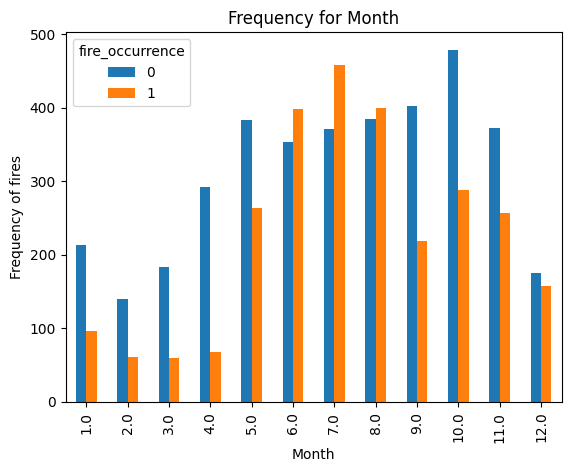

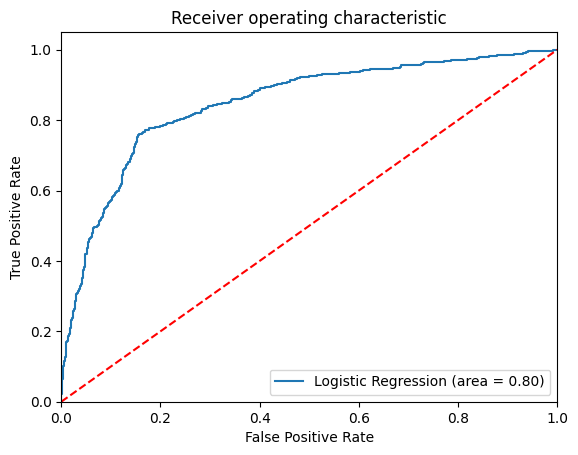

In [62]:
train_model()